In [1]:
from pyspark import SparkConf

master = 'local[*]'
app_name = 'Recommendation system'
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

In [2]:
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')

### Read the data and exploration

In [3]:
## Read the dataset
rating_df = spark.read.csv('movie_ratings_df.csv', inferSchema=True, header=True)
print(rating_df.count(), len(rating_df.columns))

100000 3


In [4]:
rating_df.show(3)
rating_df.printSchema()

+------+------------+------+
|userId|       title|rating|
+------+------------+------+
|   196|Kolya (1996)|     3|
|    63|Kolya (1996)|     3|
|   226|Kolya (1996)|     5|
+------+------------+------+
only showing top 3 rows

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [5]:
## Checking for null values
from pyspark.sql.functions import isnan, when, count, col

rating_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rating_df.columns]).show()

+------+-----+------+
|userId|title|rating|
+------+-----+------+
|     0|    0|     0|
+------+-----+------+



In [6]:
from pyspark.sql.functions import rand

rating_df.orderBy(rand()).show(10, False)

+------+------------------------------+------+
|userId|title                         |rating|
+------+------------------------------+------+
|201   |Thin Blue Line, The (1988)    |3     |
|23    |When Harry Met Sally... (1989)|4     |
|387   |Unstrung Heroes (1995)        |2     |
|886   |Braveheart (1995)             |4     |
|150   |Mars Attacks! (1996)          |4     |
|15    |Michael (1996)                |4     |
|645   |Pink Floyd - The Wall (1982)  |4     |
|435   |Paper, The (1994)             |4     |
|690   |Grease (1978)                 |4     |
|85    |Local Hero (1983)             |4     |
+------+------------------------------+------+
only showing top 10 rows



In [7]:
rating_df.describe().show()

+-------+------------------+--------------------+------------------+
|summary|            userId|               title|            rating|
+-------+------------------+--------------------+------------------+
|  count|            100000|              100000|            100000|
|   mean|         462.48475|                null|           3.52986|
| stddev|266.61442012750865|                null|1.1256735991443156|
|    min|                 1|'Til There Was Yo...|                 1|
|    max|               943|� k�ldum klaka (C...|                 5|
+-------+------------------+--------------------+------------------+



In [8]:
print(f'Titles: {rating_df.select("title").distinct().count()}, users: {rating_df.select("userId").distinct().count()}')

Titles: 1664, users: 943


In [9]:
print(f'5 star ratings: {rating_df.filter(rating_df.rating == 5).count()}')

5 star ratings: 21201


In [10]:
## Get the most active users
rating_df.groupBy('userID').count().orderBy('count', ascending=False).show(10)

+------+-----+
|userID|count|
+------+-----+
|   405|  737|
|   655|  685|
|    13|  636|
|   450|  540|
|   276|  518|
|   416|  493|
|   537|  490|
|   303|  484|
|   234|  480|
|   393|  448|
+------+-----+
only showing top 10 rows



In [11]:
## Get the least active users
rating_df.groupBy('userID').count().orderBy('count', ascending=True).show(10)

+------+-----+
|userID|count|
+------+-----+
|    19|   20|
|   636|   20|
|   572|   20|
|   596|   20|
|   631|   20|
|   685|   20|
|   926|   20|
|    34|   20|
|    93|   20|
|   300|   20|
+------+-----+
only showing top 10 rows



In [12]:
## Get the most rated movies
rating_df.groupBy('title').count().orderBy('count', ascending=False).show(10, False)

+-----------------------------+-----+
|title                        |count|
+-----------------------------+-----+
|Star Wars (1977)             |583  |
|Contact (1997)               |509  |
|Fargo (1996)                 |508  |
|Return of the Jedi (1983)    |507  |
|Liar Liar (1997)             |485  |
|English Patient, The (1996)  |481  |
|Scream (1996)                |478  |
|Toy Story (1995)             |452  |
|Air Force One (1997)         |431  |
|Independence Day (ID4) (1996)|429  |
+-----------------------------+-----+
only showing top 10 rows



In [13]:
## Get the least rated movies
rating_df.groupBy('title').count().orderBy('count', ascending=True).show(10, False)

+-----------------------------------------+-----+
|title                                    |count|
+-----------------------------------------+-----+
|Mad Dog Time (1996)                      |1    |
|Next Step, The (1995)                    |1    |
|Aiqing wansui (1994)                     |1    |
|Modern Affair, A (1995)                  |1    |
|Fear, The (1995)                         |1    |
|Leopard Son, The (1996)                  |1    |
|Lashou shentan (1992)                    |1    |
|JLG/JLG - autoportrait de d�cembre (1994)|1    |
|Target (1995)                            |1    |
|Vie est belle, La (Life is Rosey) (1987) |1    |
+-----------------------------------------+-----+
only showing top 10 rows



#### Check partitioning

In [14]:
rating_df.rdd.getNumPartitions()

1

In [15]:
# range repartition by userId
df_range = rating_df.repartitionByRange(4, 'userId')
df_range.rdd.getNumPartitions()

4

In [16]:
## Get the least active users
df_range.groupBy('userID').count().orderBy('count', ascending=True).show(10)

+------+-----+
|userID|count|
+------+-----+
|   636|   20|
|   571|   20|
|   558|   20|
|   631|   20|
|   572|   20|
|   300|   20|
|   441|   20|
|   364|   20|
|   309|   20|
|   418|   20|
+------+-----+
only showing top 10 rows



The first image shows that the task is performed by a single processor and the parallelization is not being used. However, the overhead time is reduced, since no additional processors need to perform the task.
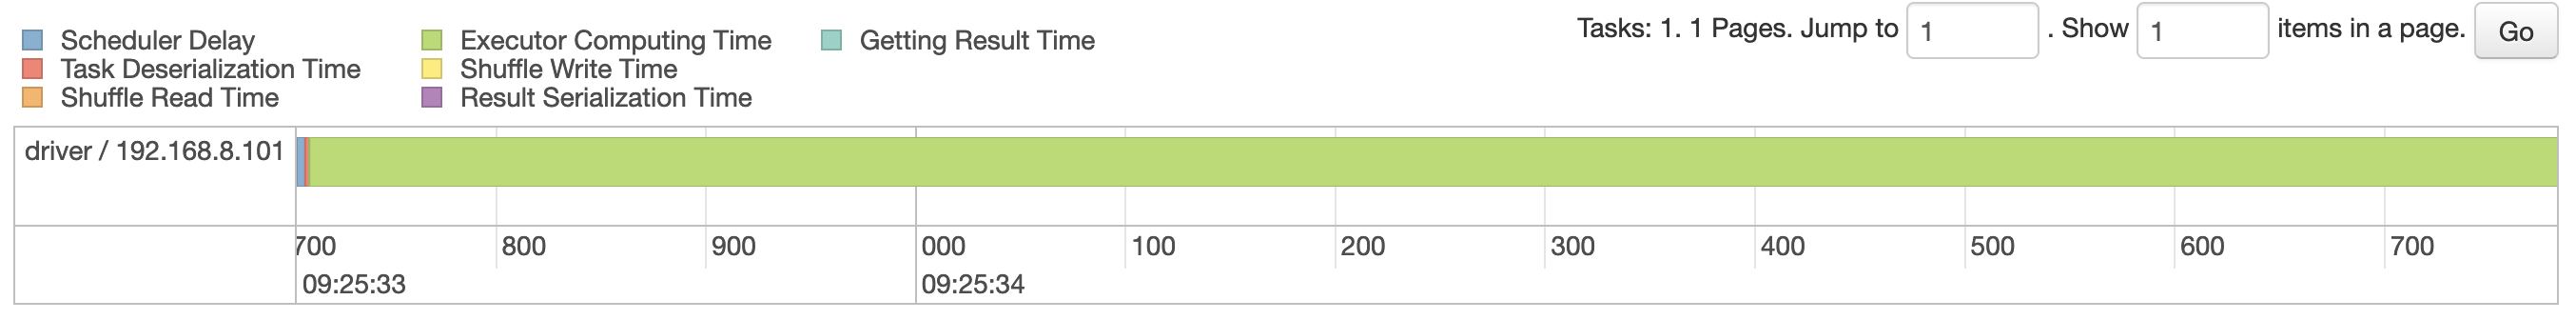

The second image shows the 4 processors working on each partition. There is some overhead time, but in more complex tasks it is worth to make use of additional workers as it offsets the overhead of splitting the task
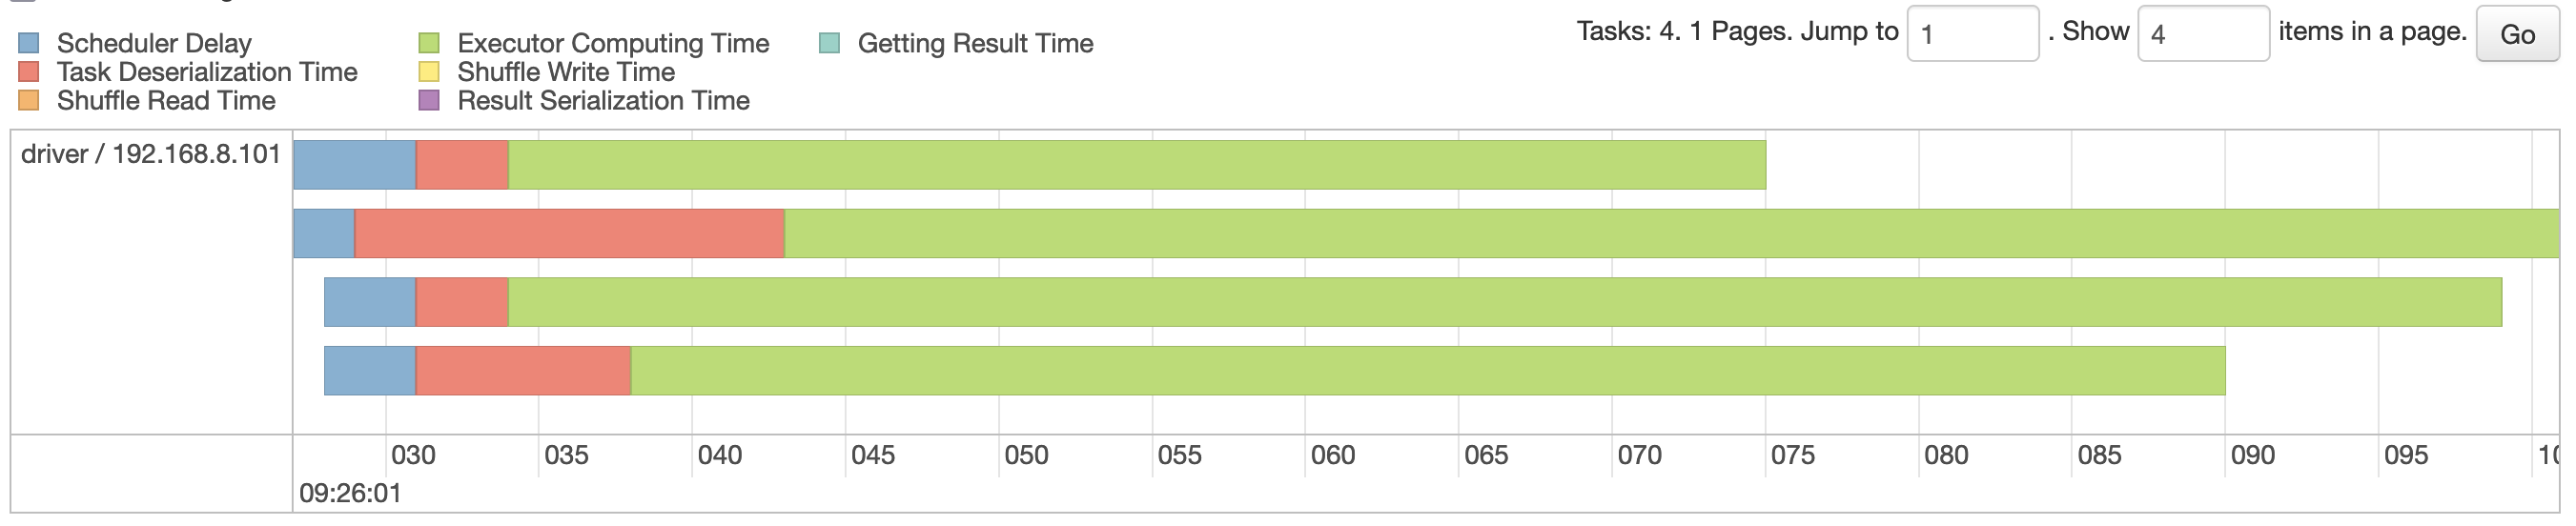

### Feature engineering

In [73]:
from pyspark.ml.feature import StringIndexer, IndexToString

indexer = StringIndexer(inputCol='title', outputCol='title_id')
model_indexer = indexer.fit(df_range)
indexed = model_indexer.transform(df_range)
indexed.orderBy(rand()).show(5)

+------+--------------------+------+--------+
|userId|               title|rating|title_id|
+------+--------------------+------+--------+
|   833|Private Parts (1997)|     4|   337.0|
|   663|        Evita (1996)|     1|    60.0|
|   859|Willy Wonka and t...|     2|    25.0|
|   298|      Vertigo (1958)|     5|   144.0|
|    10| Widows' Peak (1994)|     5|   948.0|
+------+--------------------+------+--------+
only showing top 5 rows



In [18]:
## Split the dataset
train, test = indexed.randomSplit([0.75, 0.25])
train.count()
test.count()

25006

In [19]:
## Number of rows per partition in train set
from pyspark.sql.functions import spark_partition_id

train.withColumn("partitionId", spark_partition_id()).groupBy("partitionId").count().show()

+-----------+-----+
|partitionId|count|
+-----------+-----+
|          1|18837|
|          3|19012|
|          2|19582|
|          0|17555|
+-----------+-----+



### Train the model

In [20]:
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=10, regParam=0.01, userCol='userId', itemCol='title_id', ratingCol='rating', 
          nonnegative=True, coldStartStrategy='drop') # nonnegative to avoid negative ratings

model = als.fit(train)

In [21]:
# predictions and evaluation
ratings_pred = model.transform(test)
ratings_pred.orderBy(rand()).show(10)

+------+--------------------+------+--------+----------+
|userId|               title|rating|title_id|prediction|
+------+--------------------+------+--------+----------+
|   535|Lion King, The (1...|     4|    93.0| 3.8215988|
|   880|    Cape Fear (1991)|     4|   160.0|  3.768989|
|   788|      Gattaca (1997)|     2|   229.0| 2.9794714|
|   549|101 Dalmatians (1...|     3|   308.0|  3.145955|
|   234|Clockwork Orange,...|     3|    91.0| 3.3630404|
|   210|Conan the Barbari...|     3|   311.0| 2.8169656|
|   198|Star Trek: The Wr...|     3|    72.0| 3.3289385|
|   671|   Braveheart (1995)|     4|    37.0| 4.6079483|
|   297|   Get Shorty (1995)|     1|   106.0| 3.6526647|
|   532|      Titanic (1997)|     5|    21.0| 5.8598814|
+------+--------------------+------+--------+----------+
only showing top 10 rows



In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='rating')
rmse = evaluator.evaluate(ratings_pred)
print(rmse)

0.8445228387410769


With a held out testing set we could obtain 0.8445 as RMSE. In the next section we will implement 3-fold cross validation using the complete data and see what the estimate for the RMSE is. Also, we will use a grid to fine tune the `maxIter` and `regParam` hyperparameters.
### 3-fold CV and hyperparameter tuning

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(als.maxIter, [10, 15, 20])
             .addGrid(als.regParam, [0.01, 0.05, 0.07])
             .build())

evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='rating')

In [27]:
# Create 3-fold CrossValidator
als_cv = CrossValidator(estimator = als,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 3)

In [28]:
# Run cross validations
als_cvModel = als_cv.fit(indexed) # fit the complete indexed df
print(als_cvModel)

CrossValidatorModel_147744863609


In [29]:
## Get the best model
bestModel= als_cvModel.bestModel
# bestModel.params
print('Best Parameters for ALS: ', bestModel._java_obj.paramMap())

Best Parameters for ALS:  {
	ALS_554901edea11-blockSize: 4096,
	ALS_554901edea11-coldStartStrategy: drop,
	ALS_554901edea11-itemCol: title_id,
	ALS_554901edea11-userCol: userId
}


In [34]:
import numpy as np

scores = als_cvModel.avgMetrics
idx_bestmodel = np.argmin(scores)
best_params = als_cvModel.getEstimatorParamMaps()[idx_bestmodel]
print(f'Best cv rmse: {scores[idx_bestmodel]}, \nparams: {best_params}')

Best cv rmse: 0.7834953519516863, 
params: {Param(parent='ALS_554901edea11', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_554901edea11', name='regParam', doc='regularization parameter (>= 0).'): 0.05}


In [53]:
# Model persistance
bestModel.save('recommendation_model')

After 3-cross validation the estimated RMSE is 0.783. Although it is expected to obtain a lower RMSE when changing from held out test set to CV, it is worth noting that this is a better approach since the new model is now learning from all the available ratings and the RMSE obtained is a good estimator of the test RMSE because 1/3 of the data is always kept as validation (to prevent overfitting).

### Recommend movies to users

In [54]:
# Get the unique movies in the dataframe
movies = indexed.select('title_id').distinct()
movies.count()

1664

In [76]:
from pyspark.sql.functions import lit

def recomm_movies(uid, n):
    '''recommends top n movies to the user with id uid'''
    # find the movies already watched by the user
    old_movies = indexed.filter(indexed['userID']==uid).select('title_id').distinct()
    # use left_anti join to get only the unseen movies of user uid
    movies_opts = movies.join(old_movies, movies.title_id == old_movies.title_id, how='left_anti')
    movies_opts = movies_opts.withColumn("userId",lit(int(uid)))
    recommendations = bestModel.transform(movies_opts).orderBy('prediction', ascending=False).limit(n)
    
    # add the movie title
    movie_title = IndexToString(inputCol="title_id", outputCol="title",labels=model_indexer.labels)
    top_recommendations=movie_title.transform(recommendations)
    return top_recommendations.show(n, False)

In [81]:
recomm_movies(11, 5)

+--------+------+----------+--------------------------+
|title_id|userId|prediction|title                     |
+--------+------+----------+--------------------------+
|1198.0  |11    |4.892209  |Pather Panchali (1955)    |
|302.0   |11    |4.4859877 |Close Shave, A (1995)     |
|1189.0  |11    |4.379628  |Grace of My Heart (1996)  |
|285.0   |11    |4.364522  |Wrong Trousers, The (1993)|
|657.0   |11    |4.3624625 |Persuasion (1995)         |
+--------+------+----------+--------------------------+

